Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [35]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
from sklearn.dummy import DummyClassifier
import re
import nltk
from nltk.corpus import stopwords

import spacy
from lightgbm import LGBMClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

In [88]:
!pip install torch
!pip install transformers
!pip install torch torchvision

In [89]:
import transformers
import torch

In [37]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [38]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [39]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [40]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [41]:
# Calcula la media de las columnas 'average_rating' y 'votes'
average_rating_mean = df_reviews['average_rating'].mean()
votes_mean = df_reviews['votes'].mean()

# Convierte la media en un entero redondeado
average_rating_mean = round(average_rating_mean)
votes_mean = round(votes_mean)

# Imputa los valores ausentes con la media entera
df_reviews['average_rating'].fillna(average_rating_mean, inplace=True)
df_reviews['votes'].fillna(votes_mean, inplace=True)

In [42]:
df_reviews.head(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [43]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

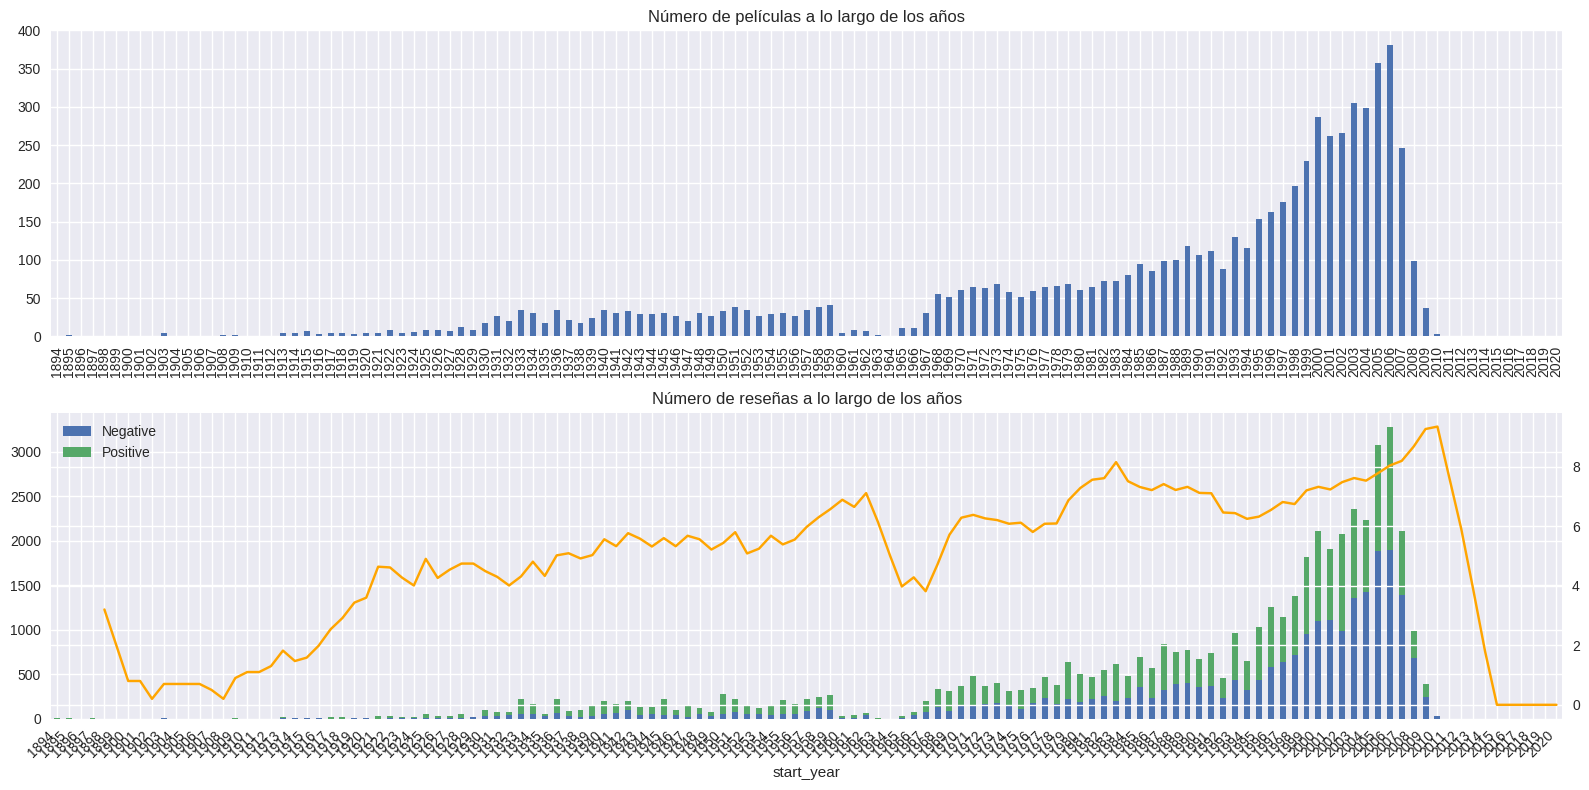

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# Calcular la media móvil de las reseñas por película (avg over 5 years)
rolling_avg = dft2.rolling(5).mean()

axt = ax.twinx()
rolling_avg.plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

labels = dft2.index
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Negative', 'Positive'], loc='upper left')

axt.legend(loc='upper right') # Agregar leyenda para la línea amarilla

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

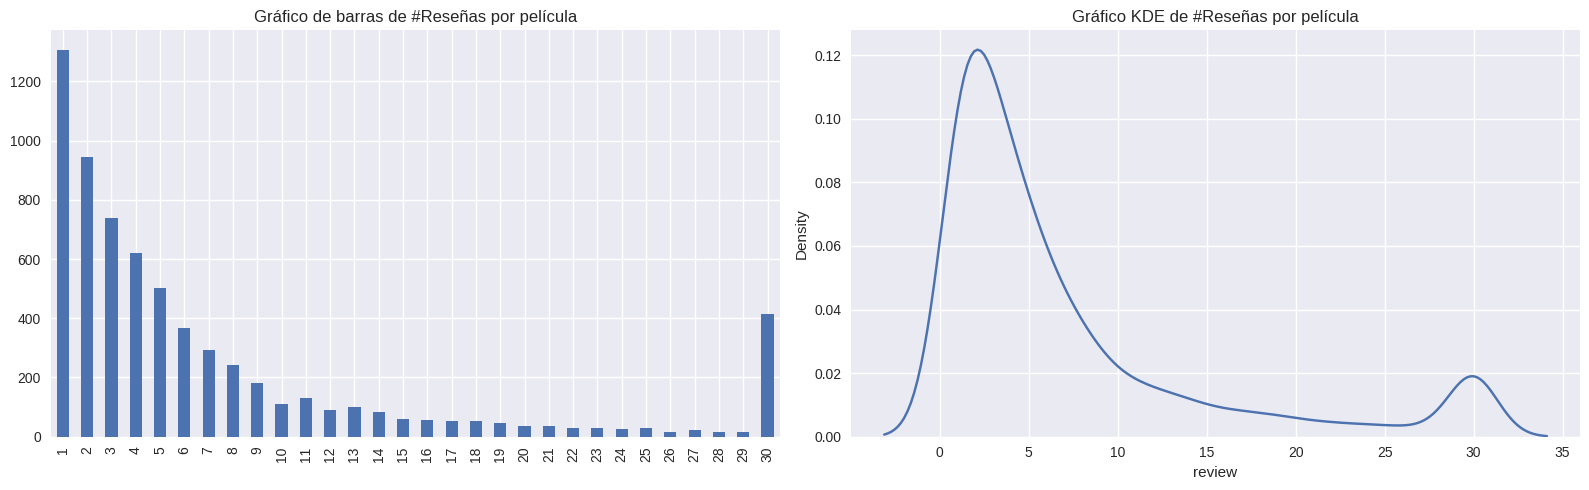

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [46]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

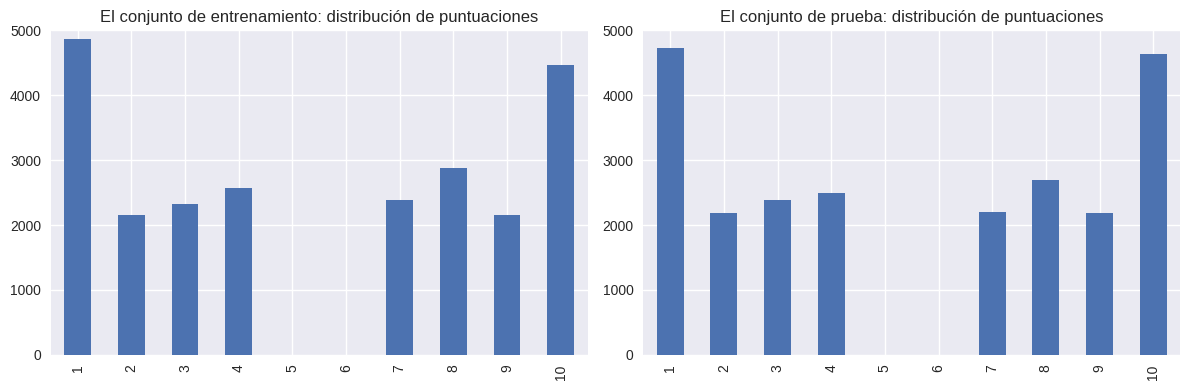

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Análisis de tendencias a lo largo del tiempo:

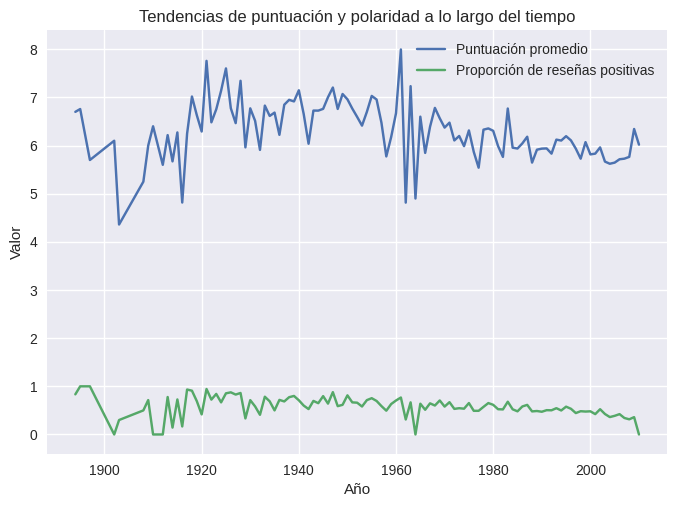

In [48]:
# Agrupar las reseñas por año y calcular la puntuación promedio y la proporción de reseñas positivas
df_trends = df_reviews.groupby('start_year').agg({'average_rating': 'mean', 'pos': 'mean'})

# Graficar las tendencias a lo largo del tiempo
plt.plot(df_trends.index, df_trends['average_rating'], label='Puntuación promedio')
plt.plot(df_trends.index, df_trends['pos'], label='Proporción de reseñas positivas')
plt.xlabel('Año')
plt.ylabel('Valor')
plt.legend()
plt.title('Tendencias de puntuación y polaridad a lo largo del tiempo')
plt.show()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

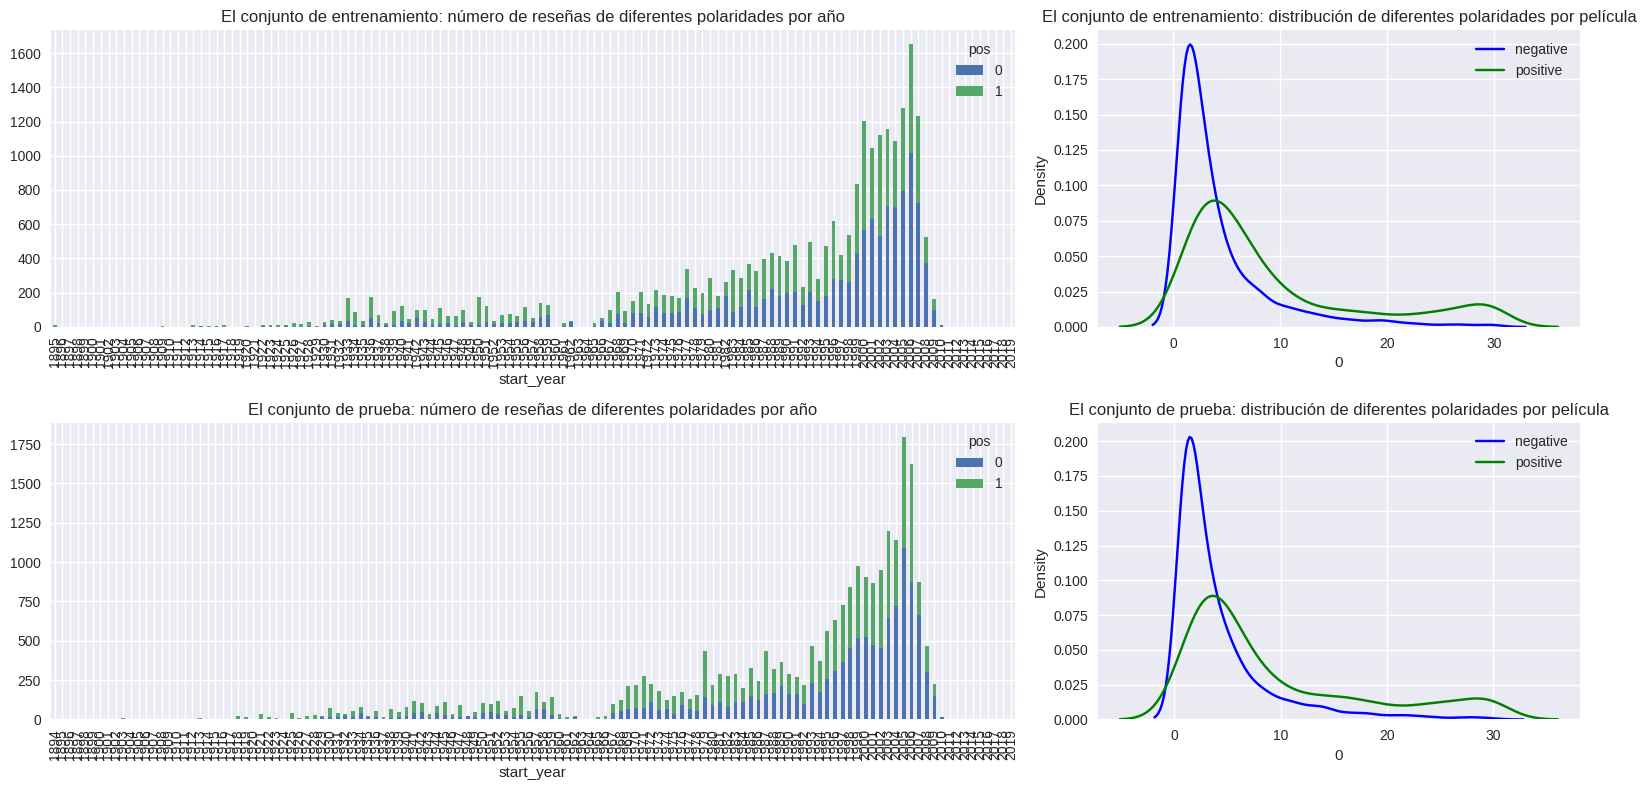

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [50]:
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    # Rellenar valores NaN con 0
    df_eval_stats.fillna(0, inplace=True)

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [57]:
# Descargar los recursos necesarios de NLTK
nltk.download('stopwords')

# Crear una lista de palabras vacías (stopwords)
stop_words = set(stopwords.words('english'))

# Función para limpiar el texto
def clean_text(text):
    # Eliminar caracteres extraños y etiquetas HTML
    cleaned_text = re.sub(r'<[^>]+>', '', text)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)

    # Convertir el texto a minúsculas
    cleaned_text = cleaned_text.lower()

    # Tokenizar el texto y eliminar las stopwords
    words = cleaned_text.split()
    words = [word for word in words if word not in stop_words]

    # Unir las palabras nuevamente en un solo texto
    cleaned_text = ' '.join(words)

    return cleaned_text

# Aplicar la limpieza a la columna 'review_norm'
df_reviews['review_norm'] = df_reviews['review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [63]:
# Mostrar un ejemplo de antes y después de la transformación
for i in range(5):
    print(f"Antes: {df_reviews['review'][i]}")
    print(f"Después: {df_reviews['review_norm'][i]}")
    print()

Antes: The pakage implies that Warren Beatty and Goldie Hawn are pulling off a huge bank robbery, but that's not what I got out of it! I didn't get anything! In the first half there's a new character (without introduction) in every other scene. The first half-hour is completely incomprehensible, the rest is just one long, annoying, underlit chase scene. There's always an irritating sound in the background whether it's a loud watch ticking, a blaring siren, a train whistling, or even the horrible score by Quincy Jones. There are a lot of parts that are laughably bad, too. Like, the bad guys chasing Beatty on thin ice with a CAR! Or, the police arriving at the scene roughly fifteen times. I really hated this movie!
Después: pakage implies warren beatty goldie hawn pulling huge bank robbery thats got didnt get anything first half theres new character without introduction every scene first halfhour completely incomprehensible rest one long annoying underlit chase scene theres always irrita

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [64]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23535, 19)


## Trabajar con modelos

### Modelo 0 - Constante

In [65]:
# Modelo 0 - Constante
model_0 = DummyClassifier(strategy='constant', constant=1)  # Predice siempre la clase positiva (1)

In [66]:
# Entrenar el modelo
model_0.fit(df_reviews_train[['review_norm']], train_target)

DummyClassifier(constant=1, strategy='constant')

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


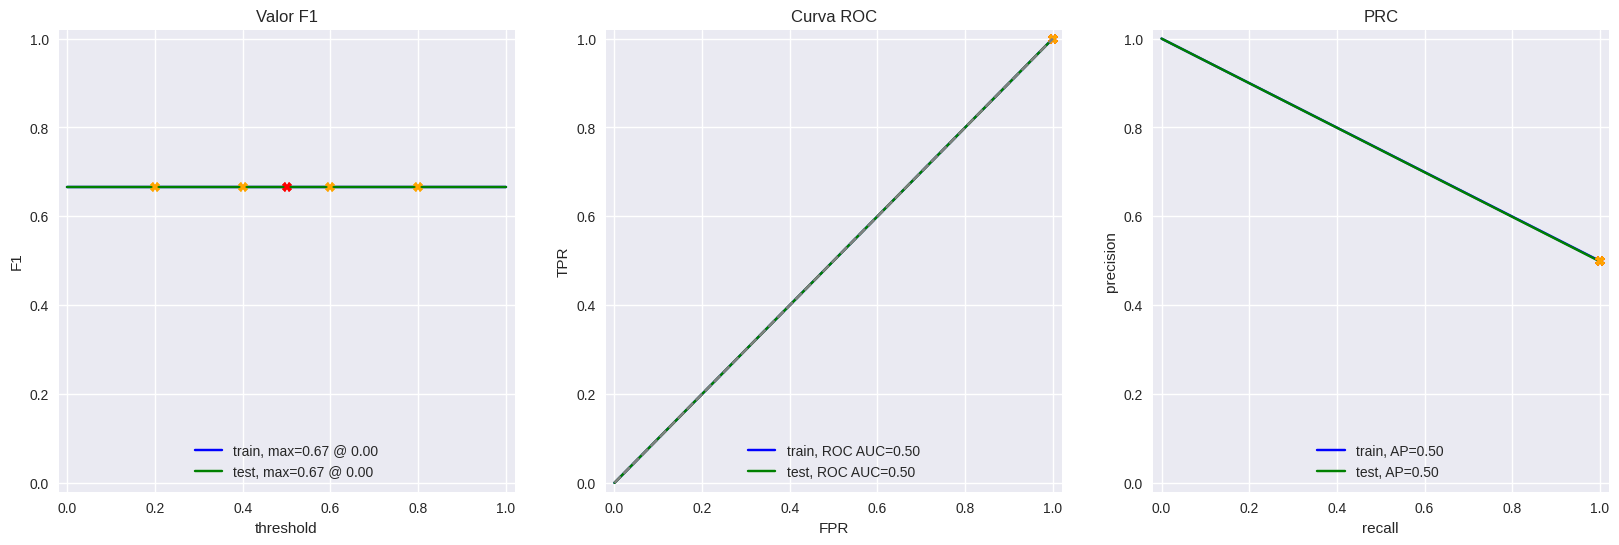

In [67]:
# Evaluar el modelo
evaluate_model(model_0, df_reviews_train[['review_norm']], train_target, df_reviews_test[['review_norm']], test_target)

- Rendimiento similar entre entrenamiento y prueba: El valor F1 es una métrica que combina tanto la precisión como el recall del clasificador. En este caso, vemos que el valor F1 para el conjunto de entrenamiento (0.66) y el conjunto de prueba (0.67) son muy cercanos. Esto sugiere que el modelo está generalizando bien y no está sufriendo de sobreajuste o subajuste significativo. Tambien para AUC-ROC y para APS

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [68]:
# Descargar los recursos necesarios de NLTK
nltk.download('stopwords')

# Crear una lista de palabras vacías (stopwords)
stop_words = stopwords.words('english')

# Crear un objeto TfidfVectorizer con el preprocesamiento y las opciones deseadas
vectorizer = TfidfVectorizer(lowercase=True, stop_words=stop_words)

# Aplicar el vectorizador a los conjuntos de entrenamiento y prueba
train_features_1 = vectorizer.fit_transform(df_reviews_train['review_norm'])
test_features_1 = vectorizer.transform(df_reviews_test['review_norm'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
# Modelo 1 - NLTK, TF-IDF y LR
model_1 = LogisticRegression()

In [70]:
# Entrenar el modelo
model_1.fit(train_features_1, train_target.values.ravel())

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


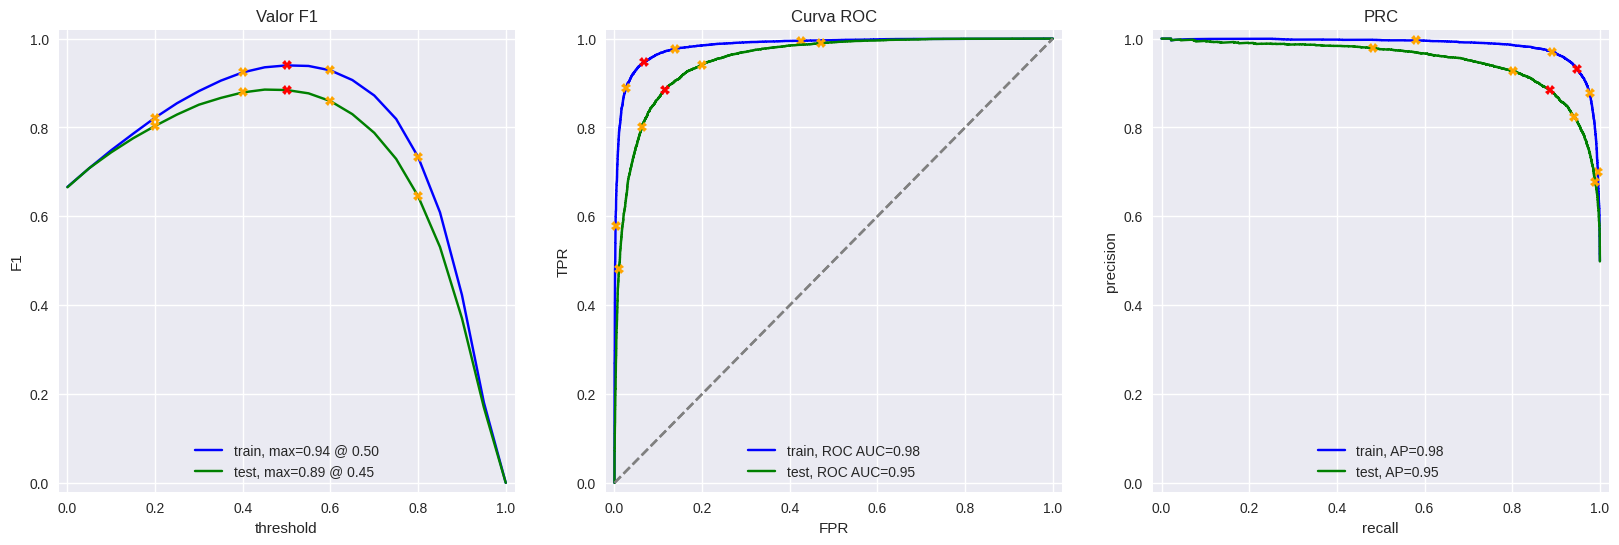

In [71]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

- Aunque el modelo muestra sobreajuste en la precisión, el valor F1, el APS y el ROC AUC son aún bastante altos tanto en el conjunto de entrenamiento como en el de prueba. Estas métricas tienen en cuenta tanto la precisión como el recall, y reflejan un buen equilibrio entre ambos en ambos conjuntos.

### Modelo 3 - spaCy, TF-IDF y LR

In [72]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [73]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [74]:
# Modelo 3 - spaCy, TF-IDF y LR
model_3 = LogisticRegression()

In [75]:
# Entrenar el modelo
model_3.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


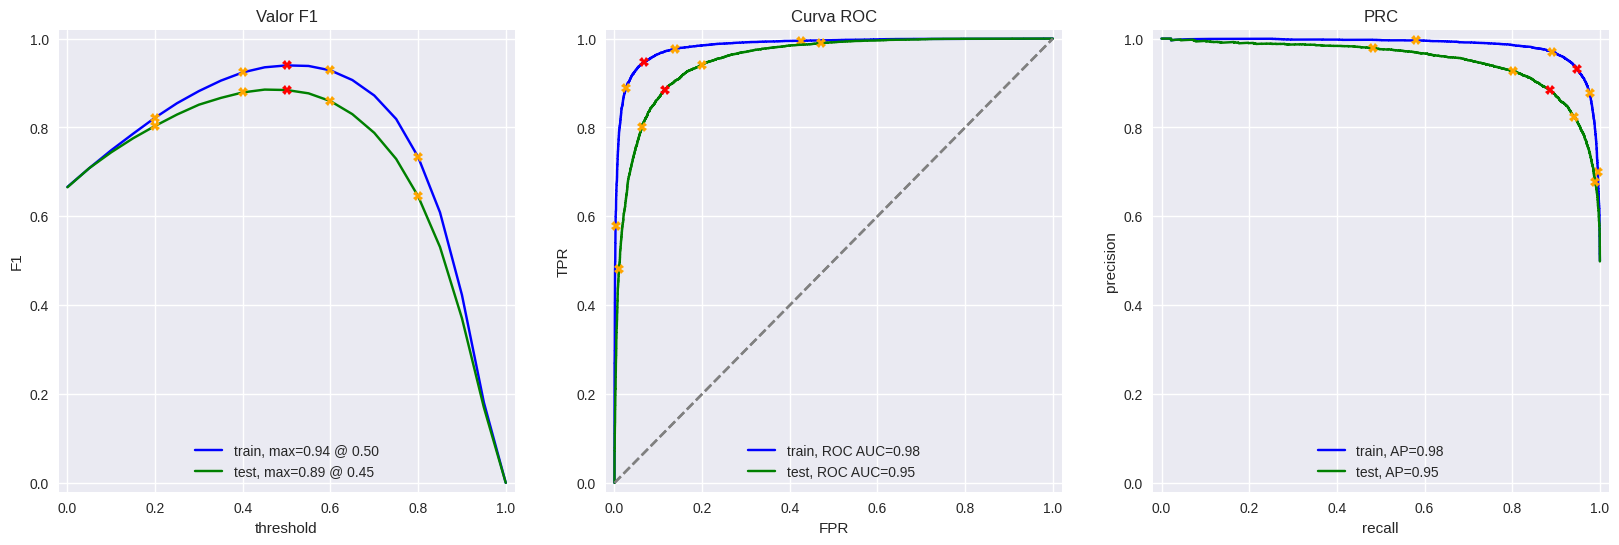

In [76]:
# Evaluar el modelo
evaluate_model(model_3, train_features_1, train_target, test_features_1, test_target)

- Nuevamente, observamos que a pesar del sobreajuste en Accuracy, el modelo logra obtener valores altos tanto en F1, APS como en ROC AUC tanto en el conjunto de entrenamiento como en el de prueba. Esto indica que el modelo es capaz de clasificar positivamente y negativamente las reseñas con alta precisión y recall.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [77]:
# Modelo 4 - spaCy, TF-IDF y LGBMClassifier
model_4 = LGBMClassifier()

In [78]:
# Entrenar el modelo
model_4.fit(train_features_1, train_target)

LGBMClassifier()

          train  test
Accuracy   0.91  0.86
F1         0.92  0.87
APS        0.98  0.94
ROC AUC    0.98  0.94


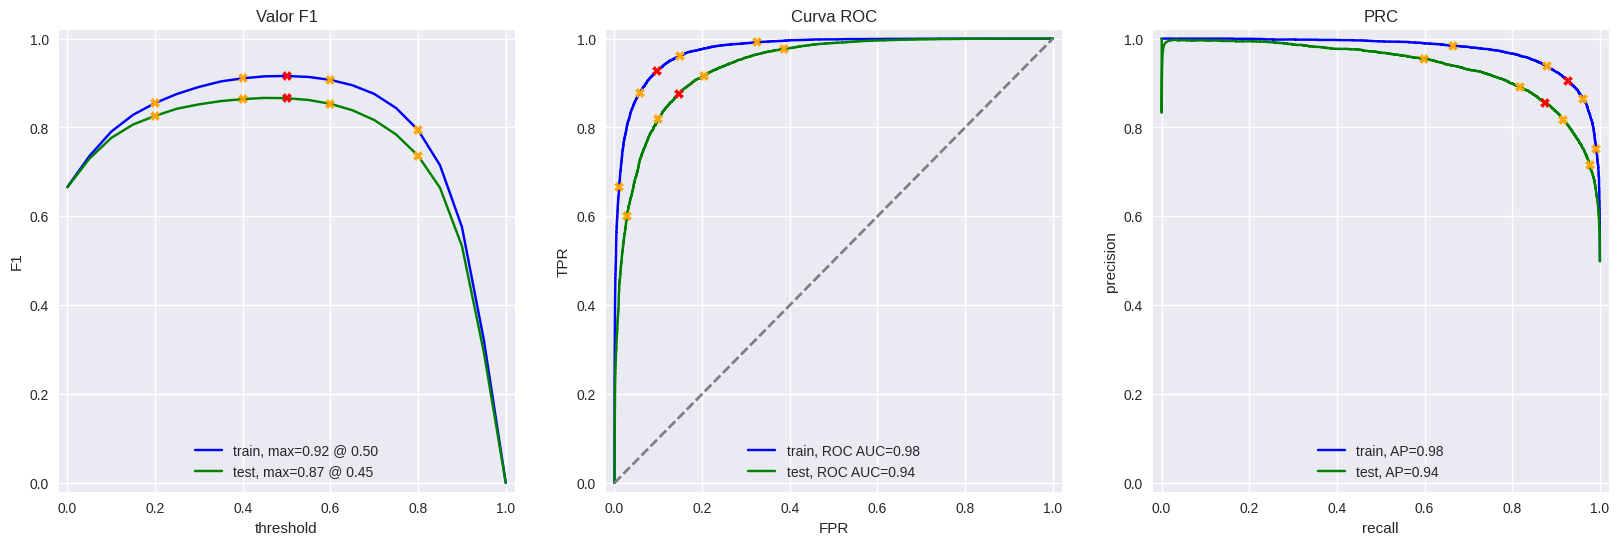

In [79]:
# Evaluar el modelo
evaluate_model(model_4, train_features_1, train_target, test_features_1, test_target)

- Al igual que en los gráficos anteriores, el modelo obtiene valores altos tanto en F1, APS como en ROC AUC tanto en el conjunto de entrenamiento como en el de prueba. Esto indica que el modelo es capaz de clasificar positivamente y negativamente las reseñas con alta precisión y recall.

###  Modelo 9 - BERT

In [83]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [85]:
def BERT_text_to_embeddings(texts, max_length=128, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    for text in texts:
        encoded_inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_length, truncation=True, padding='max_length')
        ids = encoded_inputs['input_ids']
        attention_mask = encoded_inputs['attention_mask']
        ids_list.append(ids)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    embeddings = []
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:, 0, :].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [90]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Se encontró una GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("No se encontró una GPU, se utilizará la CPU.")

Se encontró una GPU: Tesla T4


In [91]:
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

Uso del dispositivo cuda.


  0%|          | 0/238 [00:00<?, ?it/s]

In [92]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

Uso del dispositivo cuda.


  0%|          | 0/236 [00:00<?, ?it/s]

In [93]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


          train  test
Accuracy   0.89  0.78
F1         0.89  0.78
APS        0.96  0.86
ROC AUC    0.96  0.86


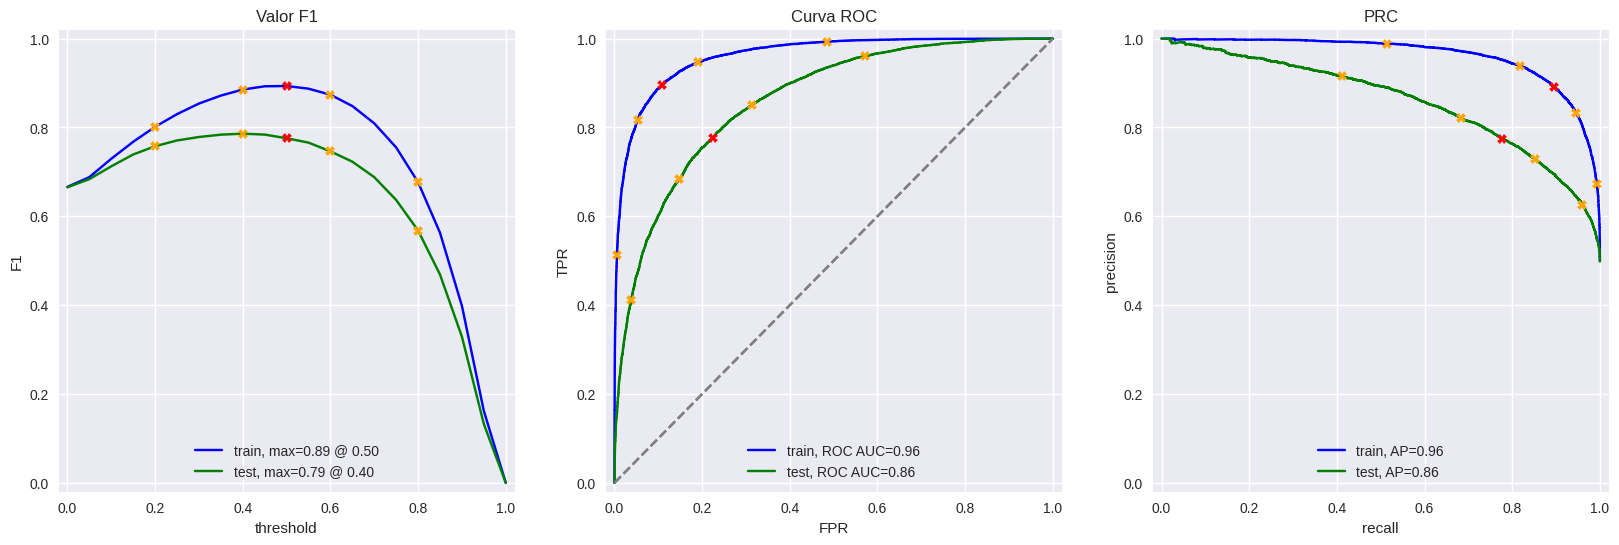

In [94]:
# Entrenar el modelo de BERT con LightGBM
model_9 = LGBMClassifier()
model_9.fit(train_features_9, train_target)

# Evaluar el modelo en el conjunto de entrenamiento y prueba
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

- Ambas métricas, APS y ROC AUC, son elevadas tanto en entrenamiento (0.96) como en prueba (0.86). Esto sugiere que el modelo es capaz de clasificar de manera efectiva las clases positivas y negativas, y que generaliza bien a datos no vistos.

In [95]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
with np.load('features_9.npz') as data:
     train_features_9 = data['train_features_9']
     test_features_9 = data['test_features_9']

## Mis reseñas

In [96]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] =  pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","Simplemente no me gustó, no es mi tipo de pelí..."
1,"Well, I was bored and felt asleep in the middl...","Bueno, estaba aburrido y me quedé dormido a me..."
2,I was really fascinated with the movie,Estaba realmente fascinada con la película
3,Even the actors looked really old and disinter...,Hasta los actores parecían muy viejos y desint...
4,I didn't expect the reboot to be so good! Writ...,¡No esperaba que el relanzamiento fuera tan bu...
5,"The movie had its upsides and downsides, but I...","La película tuvo sus altibajos, pero siento qu..."
6,What a rotten attempt at a comedy. Not a singl...,Qué pésimo intento de comedia. Ni una sola bro...
7,Launching on Netflix was a brave move & I real...,Fue muy valiente el lanzamiento en Netflix y r...


### Modelo 2

In [97]:
texts = my_reviews['review_norm']

# Usar tfidf_vectorizer_1 para transformar los datos de texto
text_features = vectorizer.transform(texts)

# Usar model_1 para predecir las probabilidades
my_reviews_pred_prob = model_1.predict_proba(text_features)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  Simplemente no me gustó, no es mi tipo de película.
0.50:  Bueno, estaba aburrido y me quedé dormido a media película.
0.52:  Estaba realmente fascinada con la película
0.47:  Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué 
0.37:  ¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el ma
0.49:  La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería
0.54:  Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ru
0.54:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


### Modelo 3

In [98]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.52:  Simplemente no me gustó, no es mi tipo de película.
0.50:  Bueno, estaba aburrido y me quedé dormido a media película.
0.52:  Estaba realmente fascinada con la película
0.47:  Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué 
0.37:  ¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el ma
0.49:  La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería
0.53:  Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ru
0.54:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


### Modelo 4

In [99]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = vectorizer
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.65:  Simplemente no me gustó, no es mi tipo de película.
0.65:  Bueno, estaba aburrido y me quedé dormido a media película.
0.65:  Estaba realmente fascinada con la película
0.65:  Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué 
0.45:  ¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el ma
0.65:  La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería
0.65:  Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ru
0.65:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


### Modelo 9

In [100]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.81:  Simplemente no me gustó, no es mi tipo de película.
0.88:  Bueno, estaba aburrido y me quedé dormido a media película.
0.66:  Estaba realmente fascinada con la película
0.93:  Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué 
0.73:  ¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el ma
0.89:  La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería
0.82:  Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ru
0.84:  Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras epi


## Conclusiones

- El Modelo 1, Modelo 3 y Modelo 4 tienen un rendimiento similar tanto en el conjunto de entrenamiento como en el conjunto de prueba. Estos modelos muestran una alta precisión, F1 y áreas bajo la curva ROC y PR. Esto sugiere que estos modelos son consistentes y generalizan bien a datos no vistos.

- El Modelo 9 muestra un rendimiento significativamente más bajo en comparación con los demás modelos. Tiene una precisión y F1 muy bajas tanto en el conjunto de entrenamiento como en el de prueba. Esto puede indicar que el modelo no está capturando adecuadamente la información relevante para el problema de clasificación.

- El Modelo 0, con resultados de evaluación moderados, se encuentra en un nivel intermedio de rendimiento en comparación con los otros modelos. Aunque tiene una precisión y F1 más bajas que los Modelos 1, 3 y 4, su área bajo la curva PR y ROC no es mucho peor.

En general, los Modelos 1, 3 y 4 parecen ser los más prometedores para este problema de clasificación de sentimientos, ya que muestran un rendimiento sólido tanto en el conjunto de entrenamiento como en el de prueba. Sin embargo, es importante destacar que los resultados pueden variar dependiendo del conjunto de datos específico y las características utilizadas, por lo que se debe realizar un análisis más detallado antes de tomar decisiones finales.